# QuantumSim - Quantum Fourier Transform

Author: Nico Kuijpers
Date: May 6, 2024

## Introduction
The Quantum Fourier Transform (QFT) is the quantum analogue of the discrete Fourier transform. 
QFT is part of many quantum algorithms including, as we will see later, Shor's algorithm.

QFT can be implemented only using Hadamard gates and phase gates.

In this Jupyter notebook we create quantum circuits for QFT and the inverse QFT using QuantumSim. The code is adapted from:

https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/quantum-fourier-transform.ipynb

In [1]:
from quantumsim import *

## Definition of QFT
QFT is the same as the classical Discrete Fourier Transform (DFT) applied to the vector of amplitudes of a quantum state with
length $N = 2^n$.

The classical Fourier transform maps vector $(x_0, x_1, \ldots, x_{N-1}) \in \mathbb{C}^N$ to vector $(y_0, y_1, \ldots, y_{N-1}) \in \mathbb{C}^N$
according to

$y_k = \frac{1}{\sqrt{N}} \sum_{n=0}^{N-1} x_n \omega_N^{-nk}$, for $k = 0, 1, 2, \ldots, N-1$,

where $\omega_N = e^{\frac{2 \pi i}{N}}$ and $\omega^n_N$ is an $N$-th *root of unity*, i.e., if $z = \omega^n_N$ then $z^N = 1$.

In a similar fashion, the quantum Fourier transform maps quantum state $|x\rangle = \sum_{i=0}^{N-1} x_i |i\rangle$ to quantum state
$\sum_{i=0}^{N-1} y_i |i\rangle$ according to

$y_k = \frac{1}{\sqrt{N}} \sum_{n=0}^{N-1} x_n \omega_N^{nk}$, for $k = 0, 1, 2, \ldots, N-1$.

Since $\omega^n_N$ is a rotation, the inverse quantum Fourier transform is similar, but with

$x_n = \frac{1}{\sqrt{N}} \sum_{k=0}^{N-1} y_k \omega_N^{-nk}$, for $n = 0, 1, 2, \ldots, N-1$.

If $|x\rangle$ is a basis state, then the quantum Fourier transform can also be expressed as the map

$\text{QFT} : |x\rangle \mapsto \frac{1}{\sqrt{N}} \sum_{k=0}^{N-1} \omega_N^{x k} |k\rangle$.

QFT can also be expressed as a unitary matrix $U_{\text{QFT}}$, where

$U_{\text{QFT}} = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} \sum_{k=0}^{N-1} \omega_N^{j k} |k\rangle\langle j|$.



## General QFT Function
Below we define helper functions *qft_rotations()* and *swap_registers()*, and function *create_qft_circuit()*.
By calling the latter with parameter $N$, a quantum circuit of $N$ qubits will be created for the Quantum Fourier Transform.

In [2]:
def qft_rotations(circuit:Circuit, n):
    if n == 0:
        return circuit
    
    # Apply Hadamard operation to the most significant qubit
    circuit.hadamard(n-1) 
    for qubit in range(n-1):
        # For each less significant qubit, a controlled rotation
        # is applied with a smaller angle.
        circuit.controlled_phase(-np.pi/2**(n-1-qubit), qubit, n-1)
    
    # Recursive function call with n-1
    qft_rotations(circuit, n-1)

def swap_registers(circuit:Circuit):
    for qubit in range(circuit.N//2):
        circuit.swap(qubit, circuit.N-qubit-1)
    return circuit

def create_qft_circuit(N):
    circuit = Circuit(N)
    qft_rotations(circuit, N)
    swap_registers(circuit)
    return circuit

In [3]:
circuit = create_qft_circuit(4)

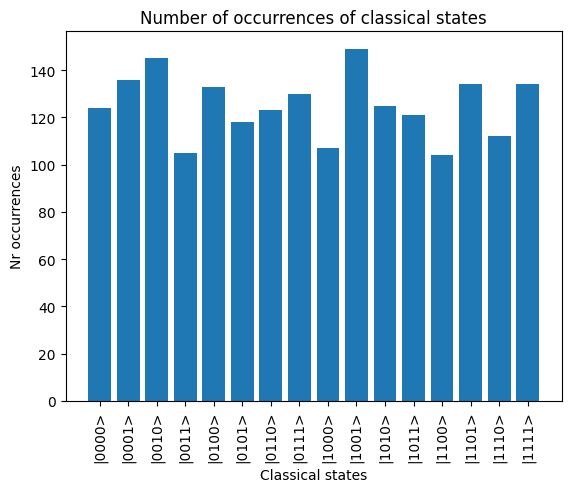

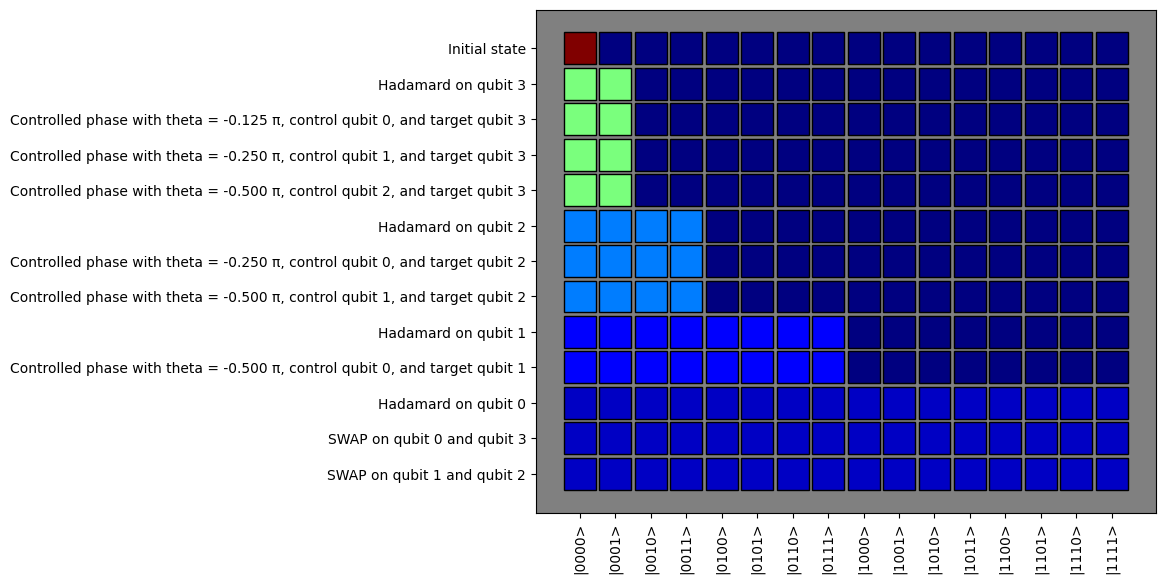

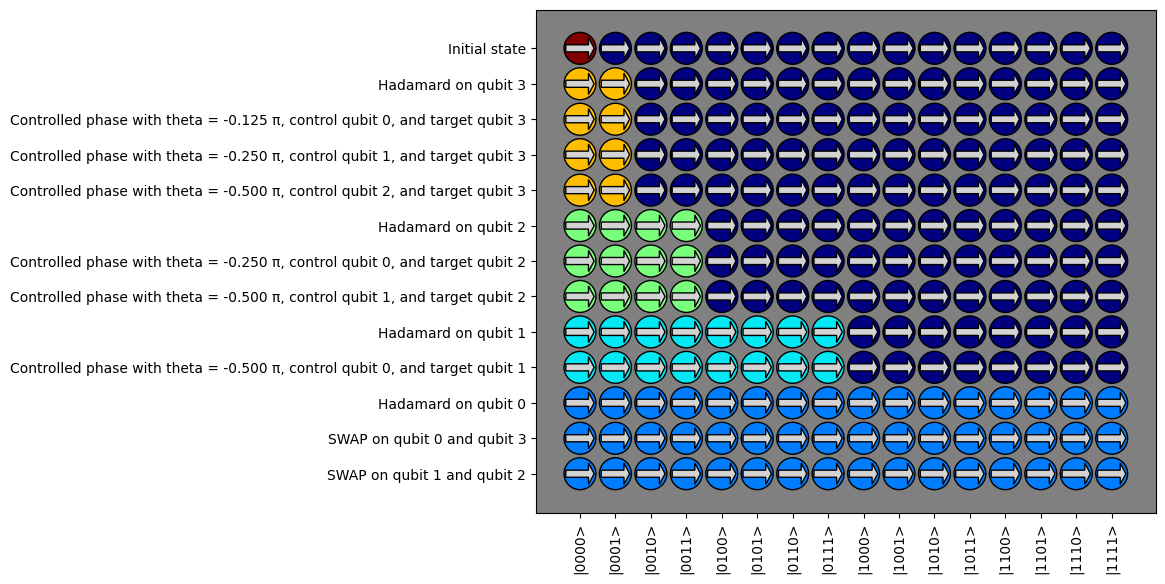

In [4]:
result = QuantumUtil.run_circuit(circuit,2000)
QuantumUtil.histogram_of_classical_states(result)
QuantumUtil.show_all_probabilities(circuit)
QuantumUtil.show_all_intermediate_states(circuit)

### Inverse Quantum Fourier Transform
A circuit for the inverse QFT can be created by reversing the unitary operations of a QFT circuit.

Below, a circuit composed of $3$ qubits is created. First, the qubits are brought into Fourier state $|\tilde{5}\rangle$. Next, a QFT circuit of $3$ qubits is created. The inverse of this circuit as an inverse QFT circuit of $3$ qubits and is appended to the first $3$-qubit circuit. After applying inverse QFT and measuring, the resulting classical state will the binary represention of $5$, which is $|101\rangle$.

In [5]:
nr_qubits = 3
number = 5
circuit = Circuit(nr_qubits)
for qubit in range(nr_qubits):
    circuit.hadamard(qubit)
circuit.phase(number*np.pi/4,0)
circuit.phase(number*np.pi/2,1)
circuit.phase(number*np.pi,2)

qft_circuit = create_qft_circuit(nr_qubits)
iqft_circuit = qft_circuit.create_inverse_circuit()
circuit.append_circuit(iqft_circuit)

# Note that the most signifact qubit is the last one. To obtain a classical state 
# representing the binary representation of number, the registers are swapped again.
swap_registers(circuit)

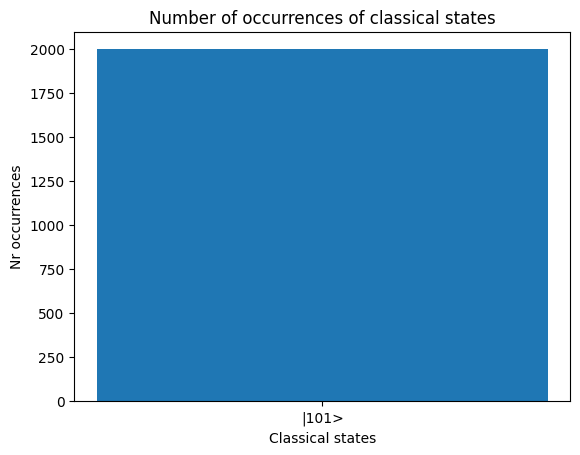

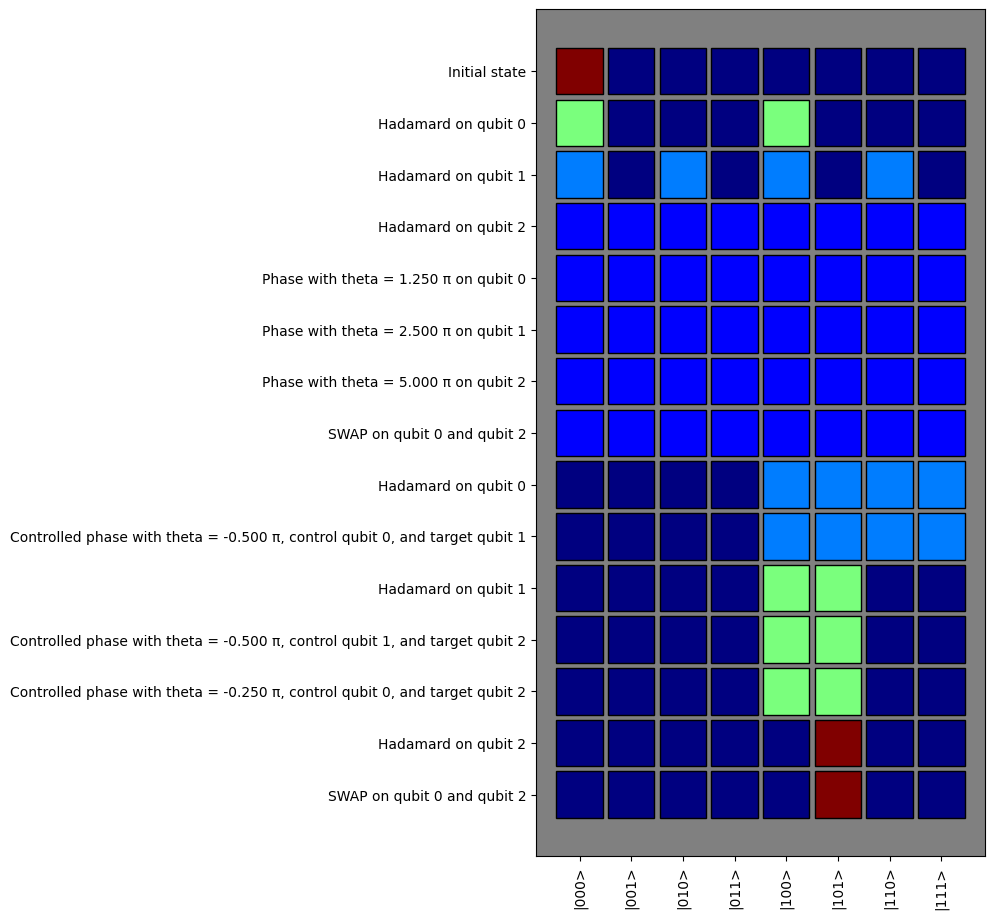

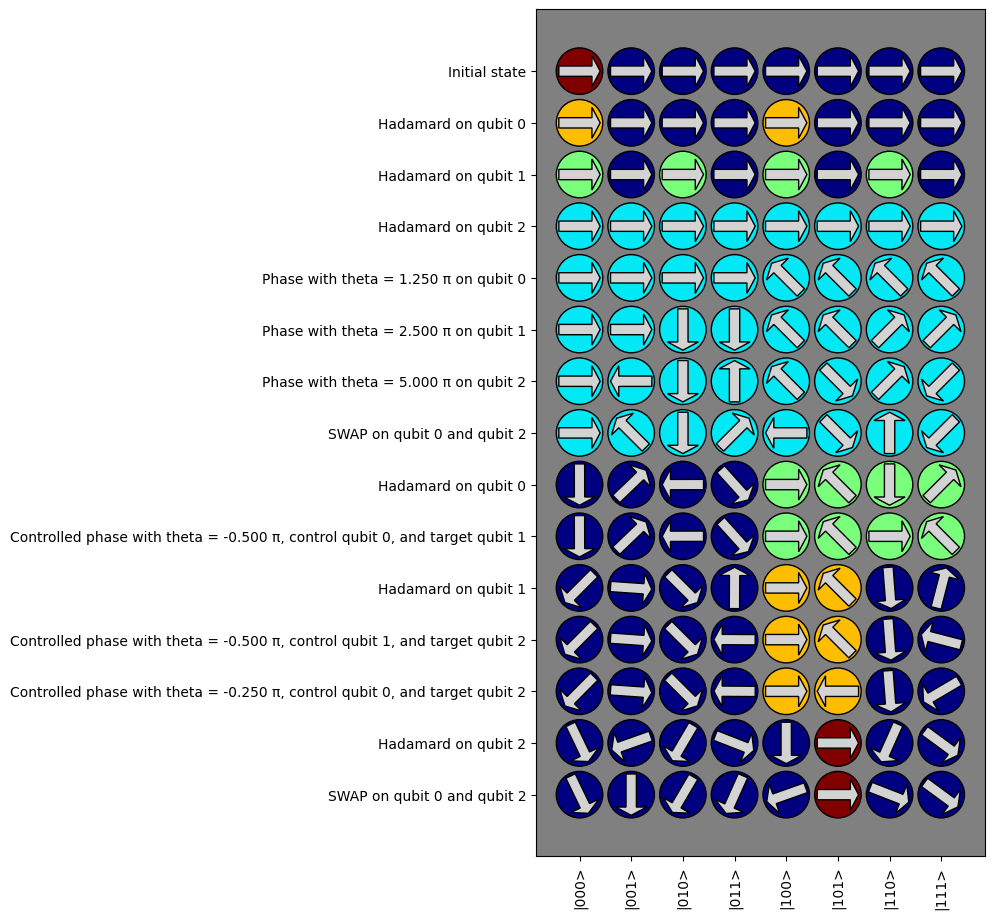

In [6]:
result = QuantumUtil.run_circuit(circuit,2000)
QuantumUtil.histogram_of_classical_states(result)
QuantumUtil.show_all_probabilities(circuit)
QuantumUtil.show_all_intermediate_states(circuit)

In [7]:
def example_qft(nr_qubits, number, nr_runs):
    circuit = Circuit(nr_qubits)
    for qubit in range(nr_qubits):
        circuit.hadamard(qubit)
    divisor = 2**(nr_qubits-1)
    for qubit in range(nr_qubits):
        circuit.phase(number*np.pi/divisor, qubit)
        divisor /= 2

    qft_circuit = create_qft_circuit(nr_qubits)
    iqft_circuit = qft_circuit.create_inverse_circuit()
    circuit.append_circuit(iqft_circuit)

    # Note that the most signifact qubit is the last one. To obtain a classical state 
    # representing the binary representation of number, the registers are swapped again.
    swap_registers(circuit)

    result = QuantumUtil.run_circuit(circuit, nr_runs)
    QuantumUtil.histogram_of_classical_states(result)
    QuantumUtil.show_all_probabilities(circuit)
    QuantumUtil.show_all_intermediate_states(circuit)

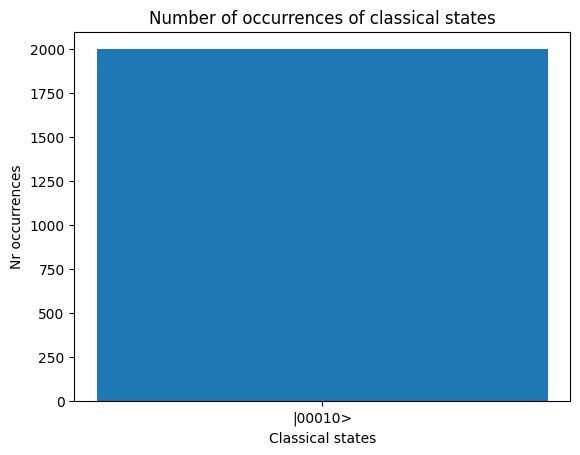

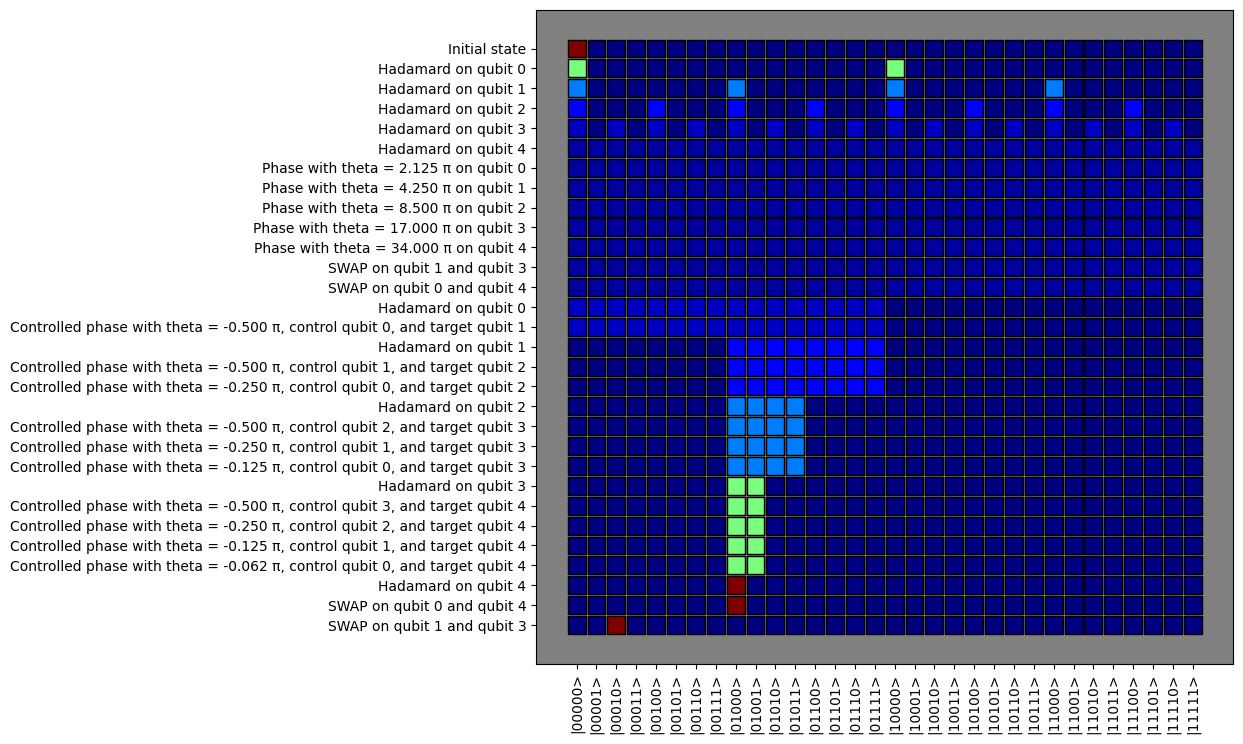

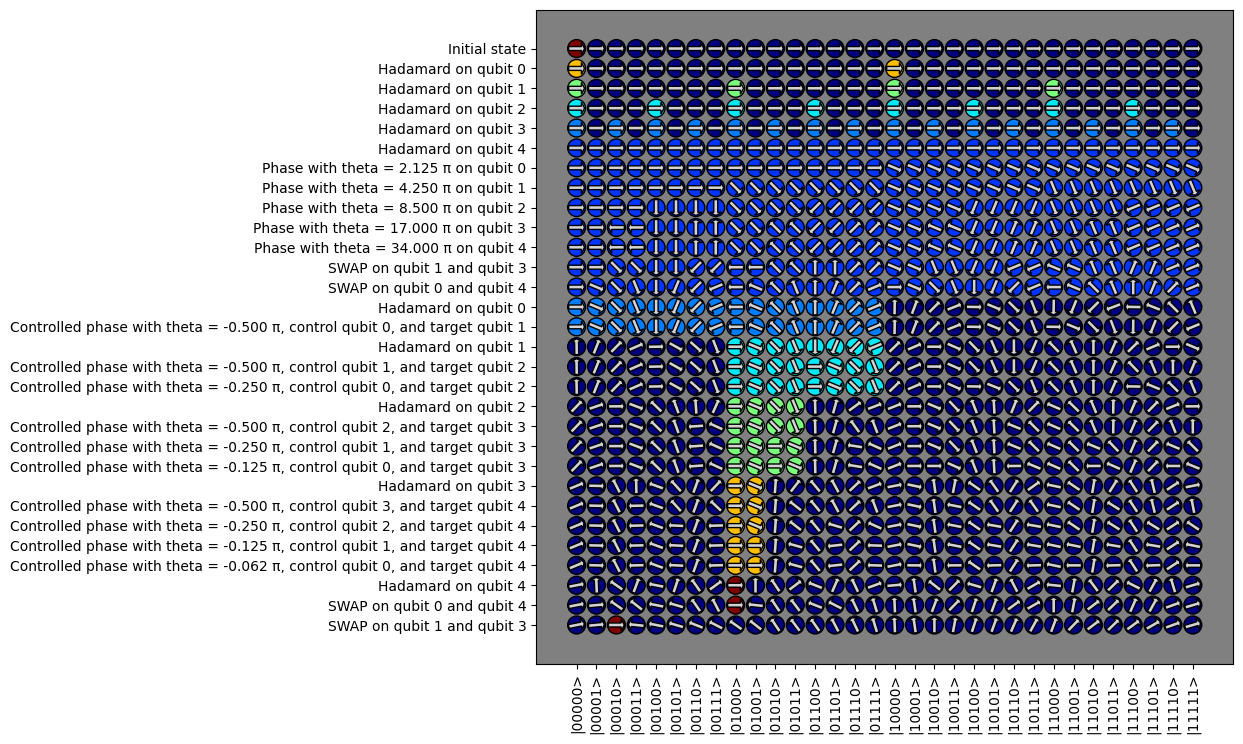

In [8]:
example_qft(5, 34, 2000)